In [1]:
import numpy as np
import pandas as pd
import anndata
import scanpy as sc
import seaborn as sns
import harmonypy as hm
import scrublet as scr
from matplotlib import rcParams
import umap

sc.settings.verbosity = 1  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=120, color_map='viridis')
sc.logging.print_versions()

-----
anndata     0.7.5
scanpy      1.7.0
sinfo       0.3.1
-----
PIL                 8.1.0
anndata             0.7.5
backcall            0.1.0
cffi                1.14.0
cloudpickle         1.6.0
colorama            0.4.4
cycler              0.10.0
cython_runtime      NA
cytoolz             0.11.0
dask                2021.02.0
dateutil            2.8.1
decorator           4.4.2
get_version         2.1
h5py                2.10.0
harmonypy           NA
igraph              0.7.1
importlib_metadata  1.5.0
ipykernel           5.1.4
ipython_genutils    0.2.0
jedi                0.16.0
joblib              1.0.1
kiwisolver          1.3.1
legacy_api_wrap     0.0.0
leidenalg           0.8.2
llvmlite            0.34.0
matplotlib          3.2.1
mkl                 2.3.0
mpl_toolkits        NA
natsort             7.1.1
numba               0.51.2
numexpr             2.7.2
numpy               1.19.2
packaging           20.9
pandas              1.1.5
parso               0.6.2
pexpect             4.8.

In [2]:
def DEG_table(adata):
    result = adata.uns['rank_genes_groups']
    groups = result['names'].dtype.names
    markers = pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
        for group in groups for key in ['names', 'pvals_adj', 'logfoldchanges']})
    return markers

In [3]:
def filtered_DEGs(adata, q_value = 1E-5, fold_change = 1):
    markers = DEG_table(adata)
    groups = adata.uns['rank_genes_groups']['names'].dtype.names
    output = pd.DataFrame()
    for i in groups:
        temp = markers[(markers.loc[:,i+'_p'] <= q_value) & (markers.loc[:,i+'_l'] >= fold_change)].loc[:,(i+'_n'):(i+'_l')]
        temp.reset_index(inplace=True, drop=True)
        output = output.join(temp, how='outer')
    return output

In [4]:
def filtered_DEG_names(adata, q_value = 1E-5, fold_change = 1):
    markers = DEG_table(adata)
    groups = adata.uns['rank_genes_groups']['names'].dtype.names
    output = pd.DataFrame()
    for i in groups:
        temp = markers[(markers.loc[:,i+'_p'] <= q_value) & (markers.loc[:,i+'_l'] >= fold_change)].loc[:,(i+'_n')]
        temp.reset_index(inplace=True, drop=True)
        output = output.join(temp, how='outer')
    return output

In [5]:
def filtered_down_reg_DEGs(adata, q_value = 1E-5, fold_change = -1):
    markers = DEG_table(adata)
    groups = adata.uns['rank_genes_groups']['names'].dtype.names
    output = pd.DataFrame()
    for i in groups:
        temp = markers[(markers.loc[:,i+'_p'] <= q_value) & (markers.loc[:,i+'_l'] <= fold_change)].loc[:,(i+'_n'):(i+'_l')]
        temp.reset_index(inplace=True, drop=True)
        output = output.join(temp, how='outer')
    return output

In [6]:
adata_orig = sc.read_h5ad('./QC_global_zfish_ven.h5ad')

In [7]:
adata_orig

AnnData object with n_obs × n_vars = 7422 × 4868
    obs: 'n_genes', 'percent_mito', 'n_counts', 'log_counts', 'percent_ribo', 'scrublet_score', 'genotype', 'Source', 'Region', 'Sample_Number', 'Sample', 'batch', 'leiden_01', 'leiden_011', 'leiden_012', 'leiden_013', 'leiden_014', 'leiden_015', 'leiden_016', 'leiden_017', 'leiden_018', 'leiden_019', 'leiden_02', 'leiden_021', 'leiden_022', 'leiden_023', 'leiden_024', 'leiden_025', 'leiden_026', 'leiden_027', 'leiden_028', 'leiden_029', 'leiden_03', 'leiden_031', 'leiden_032', 'leiden_033', 'leiden_034', 'leiden_035', 'leiden_036', 'leiden_037', 'leiden_038', 'leiden_039', 'leiden', 'leiden_annotation', 'cell_type'
    var: 'gene_ids', 'feature_types', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'Sample_colors', 'dendrogram_leiden', 'genotype_colors', 'hvg', 'leiden', 'leiden_011_colors', 'leiden_012_colors', 'leiden_013_colors', 'leiden_014_colors', 'leiden_015_colors', 'leiden_016_colors', 'le

In [8]:
adata_orig.shape

(7422, 4868)

In [9]:
print(adata_orig.X.max())
print(adata_orig.raw.X.max())

10.0
239.0


adata_subset = adata_orig[adata_orig.obs['cell_type'].isin(['Ventricular CM', 'Smooth Muscle 1?', 'AV/Ventricular conduction'])].copy()

adata_out = anndata.AnnData(X=adata_subset.raw.X, obs=adata_subset.obs, var=adata_subset.raw.var, obsm=adata_subset.obsm).copy()
adata_out.write('./myl7pos_zfish_ven_RAW.h5ad')

print(adata_orig.X.max())
print(adata_orig.raw.X.max())

In [10]:
adata_raw = anndata.AnnData(X=adata_orig.raw.X, var=adata_orig.raw.var, obs=adata_orig.obs)
sc.pp.normalize_total(adata_raw, target_sum=1e4)
sc.pp.log1p(adata_raw)
adata = adata_orig.copy()
adata.raw = adata_raw.copy()


In [11]:
# Crosstabs is a handy function for counting how many cells across .obs
pd.crosstab(adata.obs.genotype, adata.obs.cell_type)

cell_type,AV/ Ventricular Conduction Cells,CM1,CM2,CM4,Endothelial Cells,Endothelial Cells 2,Erythrocytes,Fibroblasts,Immune Cells,Pericytes,Vasculature Cells
genotype,,,,,,,,,,,
popdc1 null,123,1237,424,144,986,3,63,82,208,25,7
wildtype,62,1182,864,158,1233,16,54,99,361,63,28


In [12]:
# Crosstabs is a handy function for counting how many cells across .obs
pd.crosstab(adata.obs.Sample, adata.obs.cell_type)

cell_type,AV/ Ventricular Conduction Cells,CM1,CM2,CM4,Endothelial Cells,Endothelial Cells 2,Erythrocytes,Fibroblasts,Immune Cells,Pericytes,Vasculature Cells
Sample,,,,,,,,,,,
390-1,13,356,342,35,570,6,21,52,130,31,9
390-2,21,372,313,63,366,6,15,22,125,24,16
390-3,28,454,209,60,297,4,18,25,106,8,3
391-1,36,438,129,53,420,1,16,38,54,9,4
391-2,64,383,118,51,374,1,17,25,78,12,2
391-3,23,416,177,40,192,1,30,19,76,4,1


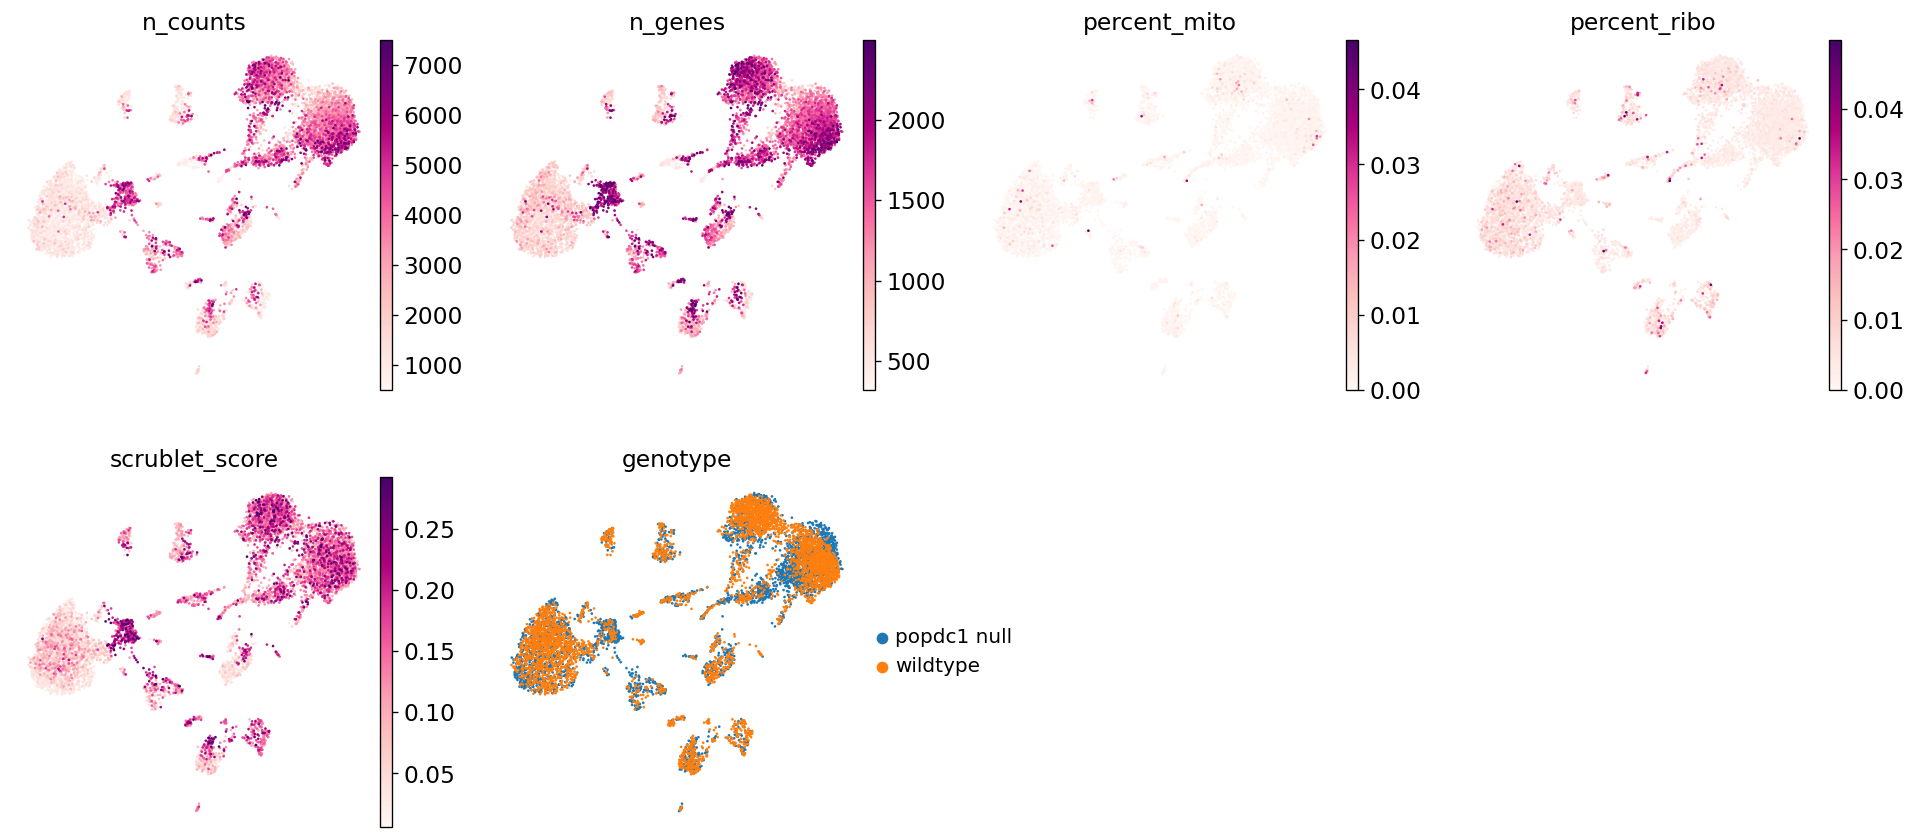

In [13]:
sc.pl.umap(adata, color = ['n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'scrublet_score', 'genotype'], size = 10, legend_fontsize = 12, frameon = False, color_map='RdPu'
          )

In [14]:
df = pd.read_csv('./percent_clusters.csv',index_col=0)
df.head(10)

,Combined,Wild Type,popdc1 null
Cluster,,,
AV/Ventricular Conduction,2.492590,1.504854,3.725015
CM1,32.592293,28.689320,37.462144
CM2,17.353813,20.970874,12.840703
CM3,4.068984,3.834951,4.360993
Endothelial Cell 1,29.897602,29.927184,29.860690
Endothelial Cell 2,0.255996,0.388350,0.090854
Fibroblasts,2.438696,2.402913,2.483343
Immune Cells,7.666397,8.762136,6.299213
Pericytes,1.185664,1.529126,0.757117


In [15]:
import matplotlib.pyplot as plt

In [16]:
df_transposed = df.T
df_transposed.head(10)

Cluster,AV/Ventricular Conduction,CM1,CM2,CM3,Endothelial Cell 1,Endothelial Cell 2,Fibroblasts,Immune Cells,Pericytes,Vasculature Cells,Erythrocytes
Combined,2.492590,32.592293,17.353813,4.068984,29.897602,0.255996,2.438696,7.666397,1.185664,0.471571,1.576395
Wild Type,1.504854,28.689320,20.970874,3.834951,29.927184,0.388350,2.402913,8.762136,1.529126,0.679612,1.310680
popdc1 null,3.725015,37.462144,12.840703,4.360993,29.860690,0.090854,2.483343,6.299213,0.757117,0.211993,1.907935


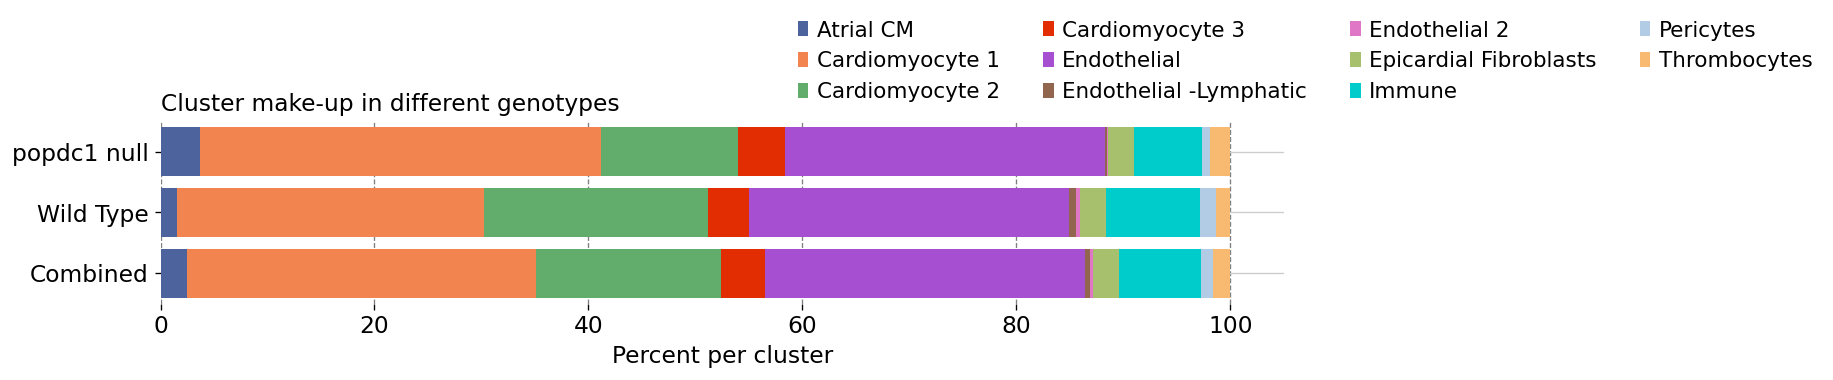

In [17]:
fields = ['AV/Ventricular Conduction','CM1','CM2','CM3', 'Endothelial Cell 1', 'Vasculature Cells', 'Endothelial Cell 2', 'Fibroblasts', 'Immune Cells', 'Pericytes','Erythrocytes']
colors = ['#4D639D', '#F2854F', '#62AD6C', '#E22C02', '#A650D1', '#92664E', '#DF77C6', '#A6C06D','#00cccc','#b3cce6','#F8B971']
labels = ['Atrial CM','Cardiomyocyte 1','Cardiomyocyte 2','Cardiomyocyte 3', 'Endothelial', 'Endothelial -Lymphatic', 'Endothelial 2', 'Epicardial Fibroblasts', 'Immune', 'Pericytes','Thrombocytes',]
# figure and axis
fig, ax = plt.subplots(1, figsize=(12, 2))
# plot bars
left = len(df_transposed) * [0]
for idx, name in enumerate(fields):
    plt.barh(df_transposed.index, df_transposed[name], left = left, color=colors[idx])
    left = left + df_transposed[name]
# title, legend, labels
plt.title('Cluster make-up in different genotypes', loc='left')
plt.legend(labels, bbox_to_anchor=([0.55, 1, 0, 0]), ncol=4, frameon=False)
plt.xlabel('Percent per cluster')
# remove spines
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
# adjust limits and draw grid lines
plt.ylim(-0.5, ax.get_yticks()[-1] + 0.5)
ax.set_axisbelow(True)
ax.xaxis.grid(color='gray', linestyle='dashed')
plt.show()

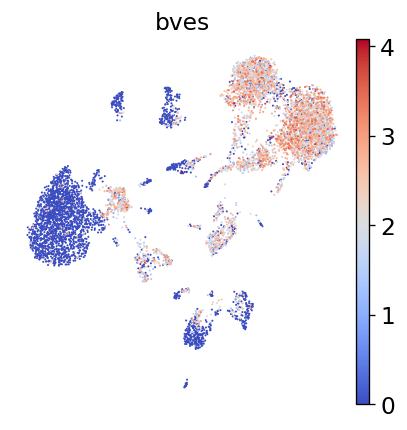

In [18]:
sc.pl.umap(adata, color = ['bves'
                              ], size = 6, legend_fontsize = 14, frameon = False, ncols=1, use_raw=True, color_map='coolwarm')

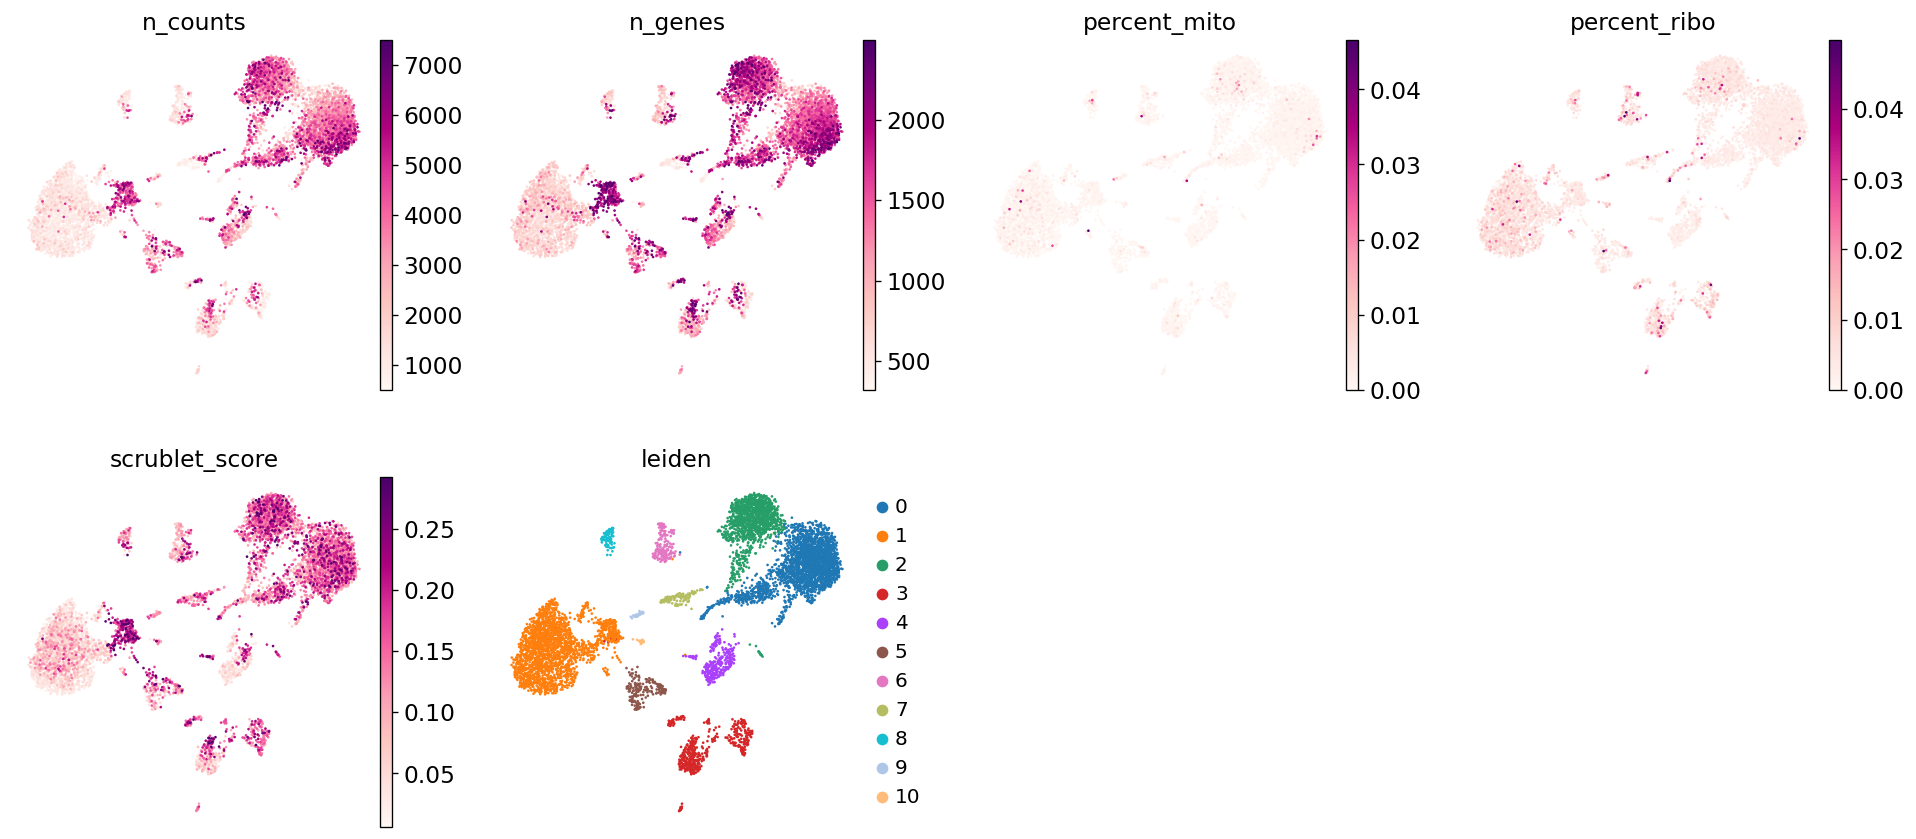

In [19]:
sc.pl.umap(adata, color = ['n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'scrublet_score', 'leiden'], size = 10, legend_fontsize = 12, frameon = False, color_map='RdPu'
          )

In [20]:
adata.obs['cell_type'] = adata.obs['cell_type'].astype(str)
old_names = ['CM1', 'Endothelial Cells', 'CM2', 'Immune Cells', 'CM4', 'AV/ Ventricular Conduction Cells', 'Fibroblasts', 'Erythrocytes', 'Pericytes', 'Vasculature Cells', 'Endothelial Cells 2']
new_names = ['Cardiomyocyte 1', 'Endothelial', 'Cardiomyocyte 2', 'Immune', 'Cardiomyocyte 3', 'Atrial CM', 'Epicardial Fibroblasts', 'Thrombocyte', 'Pericyte', 'Endothelial - Lymphatic', 'Endothelial 2']
adata.obs['cell_type'] = adata.obs['cell_type'].map(dict(zip(old_names, new_names))).astype('category')

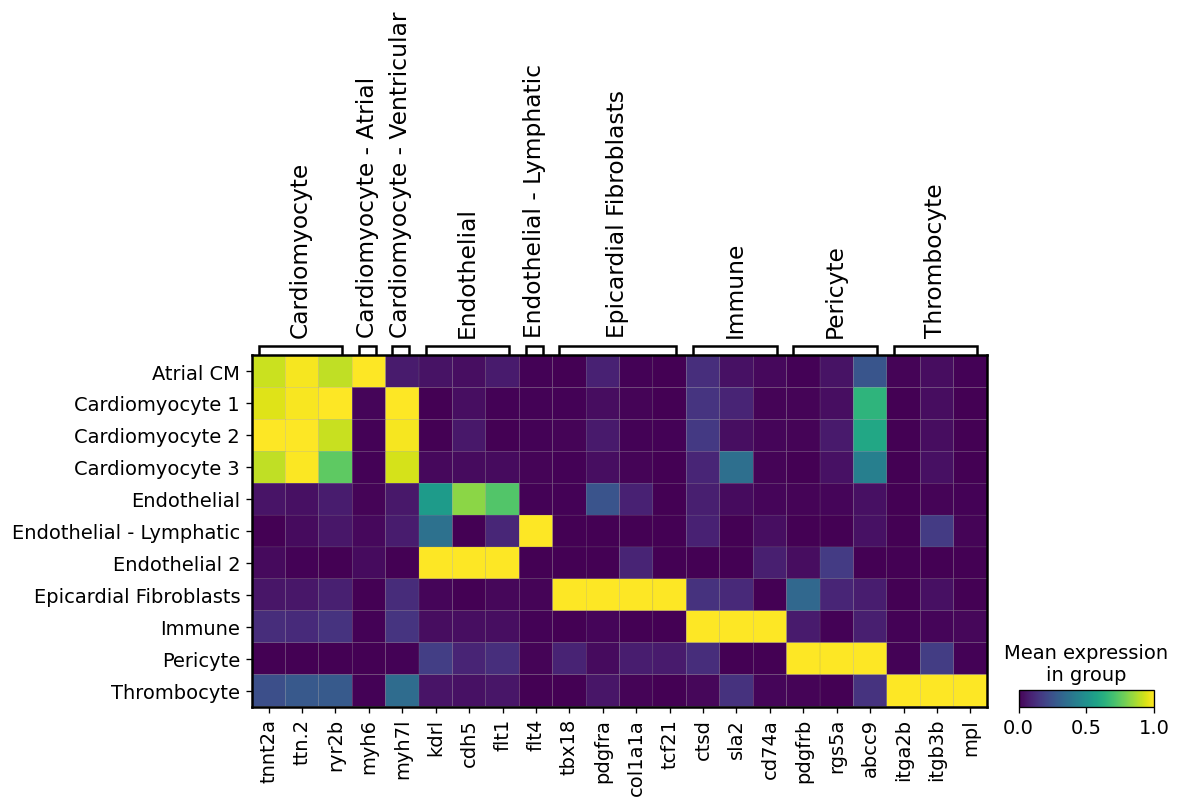

In [21]:
 l3_marker_genes_dict = {'Cardiomyocyte': ['tnnt2a','ttn.2','ryr2b'],
                         'Cardiomyocyte - Atrial': ['myh6'], #also not too sure what this group is? https://www.nature.com/articles/ncomms4153
                        'Cardiomyocyte - Ventricular': ['myh7l'], #tnnc1 and tnnt2a from honkoops # myl7 from koth # myh7l is well know marker in the fish
                        'Endothelial': ['kdrl', 'cdh5', 'flt1'], #flt1 and kdrl; are from koth paper cdh5 from michela and honkoops/ also 'vwf', which i removed from michela mamer
                       'Endothelial - Lymphatic': ['flt4'],  # i guess these are endothelial # fli is a markert of andiogenesis
                       'Epicardial Fibroblasts': ['tbx18','pdgfra','col1a1a','tcf21'], #pdgfra (c), col1a1a (d), lum (e), and dcn https://www.nature.com/articles/s41467-020-16552-7 general fibroblast markers/ I also used dcn from michaela heart paper/i removed these which I had in before , 'tcf21', 'tbx18', 'col6a3'
                       'Immune': ['ctsd','sla2','cd74a'], #ctsd honkoops paper/ sla2  and ccr9a kopth paper/ #cd74a koth paper/ mpeg well known/ tnfb from this paper https://www.frontiersin.org/articles/10.3389/fimmu.2019.00832/full#:~:text=Tnfa%20is%20one%20of%20the,or%20barely%20expressed%20(il6).
                        'Pericyte': ['pdgfrb', 'rgs5a', 'abcc9'],#rgs5 and abcc9 are from michela human paper/ lots of info on pdgfr being a pericyte maerker eg https://www.ahajournals.org/doi/10.1161/circ.138.suppl_1.14818#:~:text=Pericytes%20are%20perivascular%20mural%20cells,as%20neural%20progenitors%20and%20myofibroblasts.     #'Smooth Muscle': ['tagln','myh11a','acta2'], #all from michela heart paper? maybe my smooth muscle population arent really very smooth muscle
                       'Thrombocyte': ['itga2b','itgb3b', 'mpl']} #i removed these 'lmo2', 'tal1', / hbba and hbaa are in the koth paper and are well known/ i removed these 'hbba2','hbaa2'
                       


sc.pl.matrixplot(adata, var_names=l3_marker_genes_dict, groupby='cell_type'
                 ,standard_scale = 'var'
                ,use_raw=True
)
   

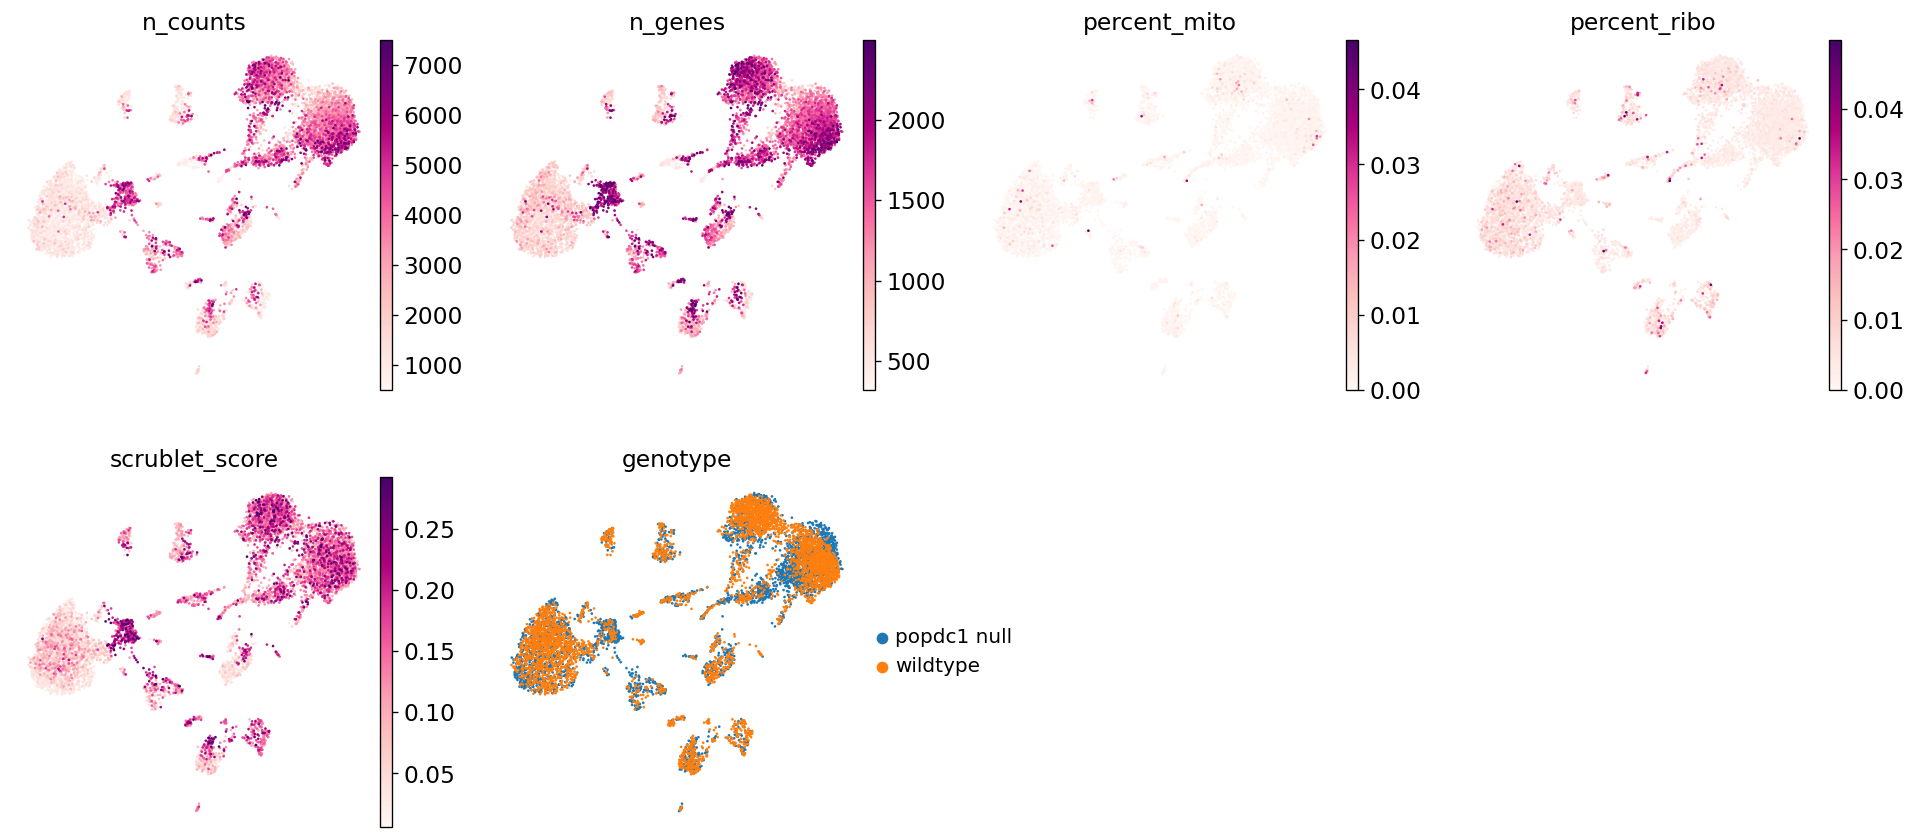

In [22]:
sc.pl.umap(adata, color = ['n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'scrublet_score', 'genotype'], size = 10, legend_fontsize = 12, frameon = False, color_map='RdPu'
          )

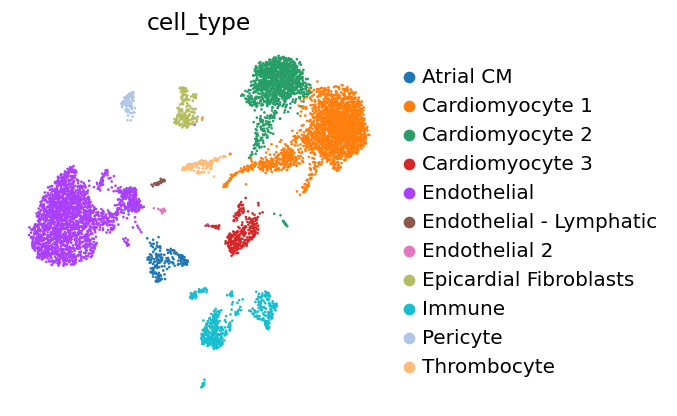

In [23]:
sc.pl.umap(adata, color = [ 'cell_type'], size = 10, legend_fontsize = 12, frameon = False, color_map='RdPu'
          )

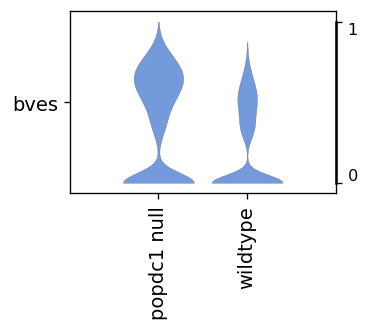

In [26]:
pl = sc.pl.stacked_violin(adata, var_names=['bves'], groupby='genotype', figsize=[5,2], swap_axes = True, standard_scale = 'var', return_fig=True)
pl.style(yticklabels = True, y_padding = 0, row_palette =('cornflowerblue'), ylim =(0,1)).show()


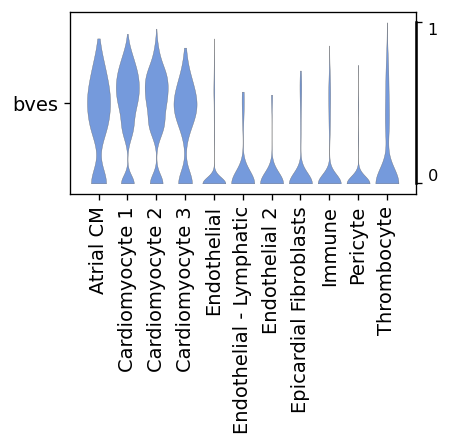

In [28]:
pl = sc.pl.stacked_violin(adata, var_names=['bves'], groupby='cell_type', figsize=[6,2], swap_axes = True, standard_scale = 'var', return_fig=True)
pl.style(yticklabels = True, y_padding = 0, row_palette =('cornflowerblue'), ylim =(0,1)).show()